Downloads ERA5 reanalysis data and collects temperature variables for lakes in BAWLD-CH4 and HydroLAKES. Includes methods development for BAWLD-CH4 methane regression and validation of BAWLD-CH4 lakea areas.

## Load data

In [9]:
## Imports
import os, sys
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from statsmodels.formula.api import ols
import xarray as xr
import cdsapi
import urllib3
import cartopy.crs as ccrs

sys.path.append('..')
from LAD import LAD, BinnedLAD, confidence_interval_from_extreme_regions

# import powerlaw

analysis_dir = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/'
# roi_pth = '/Volumes/thebe/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp' # for small UAVSAR rois
season = 'jja' # or 'ann'
maxArea = 5000 # km2 include only lakes less than this for calc

###### vars
''' Vars 'dataset', 'roi_region', 'run' are used to generate output filename.'''
###########
# HL vars
dataset = 'HL'
variables = {'id_':'Hylak_id', 'gridcell_':'BAWLDCell_', 'area_':'Shp_Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # Note: need t o join in lat/long
gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
# gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD-NAHL
useROI = False
roi_region = 'BAWLD' #'WBD' # 'Baker' # PAD, Daring, YF
run=10
# roi_pth = '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/WBD_convex_hull.shp' # for WBD roi
areaConversionFactor = 1 # because area already in m2
runNote = 'With ERA5'

################ auto update vars
#################################

## Def output paths
joined_clim_dir = os.path.join(analysis_dir, 'joined_climate', f'run{run:02}')
# summ_file_pth = os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_summ.csv')
# logFile_pth = os.path.join(joined_clim_dir, f'logfile_run{run:02}.txt')

## Make dirs
os.makedirs(joined_clim_dir, exist_ok=True)

In [2]:
## Load
bawld_dir = '/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/'
df = pd.read_csv(os.path.join(bawld_dir, 'BAWLD_CH4_Aquatic.csv'),
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## View
df.head(2)


,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,PH,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,7.05,NaN,LL,L,NaN,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,7.05,NaN,MLPe,M,Pe,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610


## Find D vs E ratio

In [3]:
df['CH4.E.FRAC'] = df['CH4.E.FLUX'] / (df['CH4.E.FLUX'] + df['CH4.D.FLUX'])
df['CH4.E.FRAC']

0           NaN
1      0.592593
2           NaN
3           NaN
4           NaN
         ...   
548    0.566613
549         NaN
550         NaN
551         NaN
552         NaN
Name: CH4.E.FRAC, Length: 553, dtype: float64

In [4]:
## How many missing ebullition that will get filled?

np.isnan(df.dropna(subset=['SA', 'LAT', 'LONG', 'YEAR.S','MONTH', 'CH4.D.FLUX'])['CH4.E.FLUX']).sum()

203

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Text(37.597222222222214, 0.5, 'Ebullition fraction')

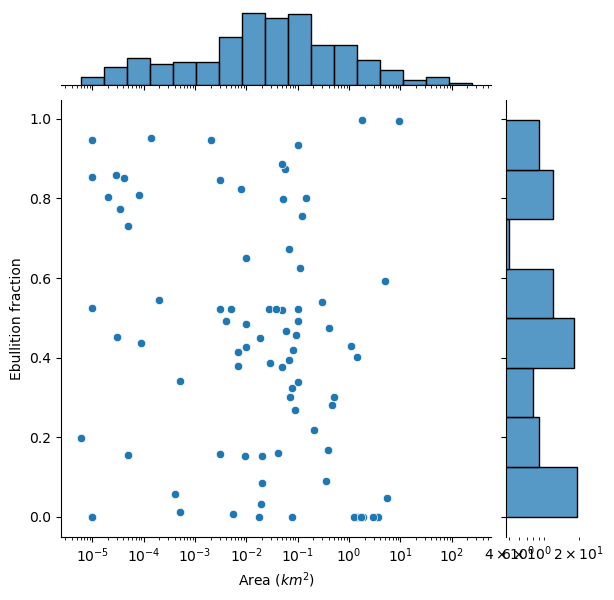

In [5]:

sns.jointplot(df, x='SA', y='CH4.E.FRAC', marginal_kws={'log_scale': (True, False)})
plt.xlabel('Area ($km^2$)')
plt.ylabel('Ebullition fraction')
# plt.xscale('log')

In [6]:
## Compute area-weighted E fraction (compare to 54% from Matthews/Wik)
df1 = df.dropna(subset=['SA', 'CH4.E.FRAC'])
# df1[['SA', 'CH4.E.FRAC']]
np.average(df1['CH4.E.FRAC'], weights=df1.SA)

0.36682934843156234

### Now filter

In [7]:
## Add total lake flux column (to match LAD.py)
eb_scaling = 0.580
df['CH4.E.FLUX'].fillna(df['CH4.D.FLUX'] * eb_scaling, inplace=True) # Placeholder until I find ratio
df['CH4.D.FLUX'].fillna(df['CH4.E.FLUX'] / eb_scaling, inplace=True) # Placeholder until I find ratio
df['CH4.DE.FLUX'] = df['CH4.D.FLUX'] + df['CH4.E.FLUX']

## Filter and pre-process
df.dropna(subset=['SA', 'CH4.DE.FLUX', 'LAT', 'LONG', 'YEAR.S','MONTH'], inplace=True) # 'TEMP'

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')


Filtered out 190 values (363 remaining).
Variables: Index(['ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.E.FRAC',
       'CH4.DE.FLUX'],
      dtype='object')


## Exploratory data analysis   

### Plot metadata

Text(0.5, 0, 'Mg CH4 / m2 /day')

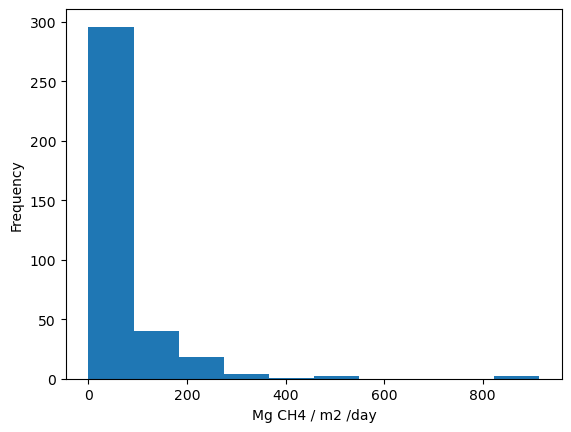

In [15]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

<Axes: xlabel='GRID_T', ylabel='CH4.DE.FLUX'>

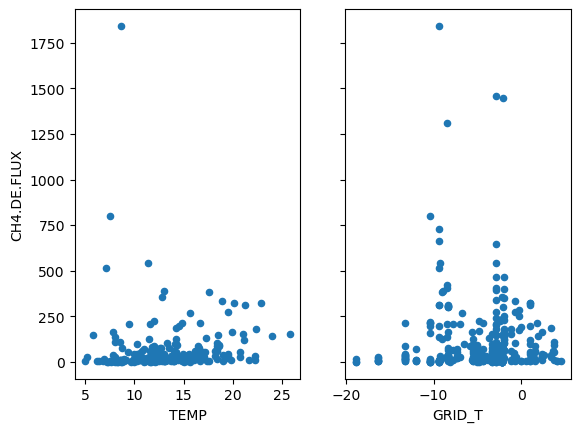

In [16]:
## Plot
_, ax = plt.subplots(1,2, sharey=True)
# df1.plot.scatter(x='TEMP', y='GRID_T')
df.plot.scatter(x='TEMP', y='CH4.DE.FLUX', ax=ax[0])
df.plot.scatter(x='GRID_T', y='CH4.DE.FLUX', ax=ax[1])

In [17]:
## How many missing entries for temp and GRID_T?
np.sum(np.isnan(df.TEMP))
np.sum(np.isin(df.MONTH, ''))
np.sum(np.isnan(df.GRID_T))

3

<Axes: ylabel='Frequency'>

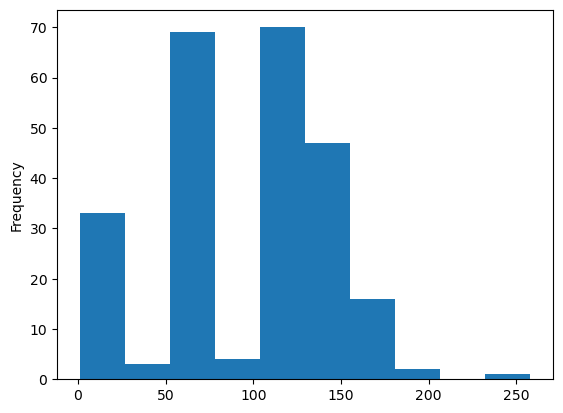

In [18]:
## How long were most studies?
df.LENGTH.plot.hist()

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='D.DAYS', ylabel='Count'>

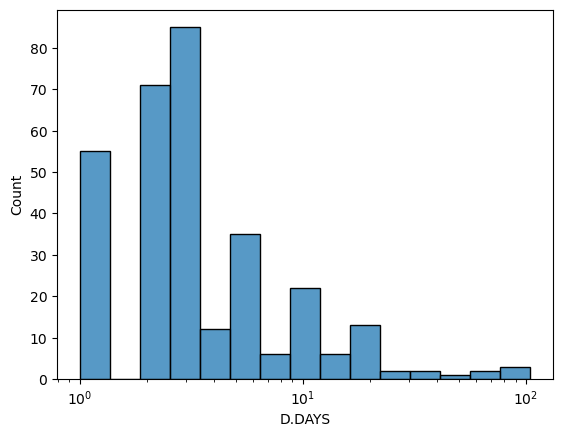

In [19]:
## How many sampling days?
sns.histplot(df, x='D.DAYS', log_scale=10)

.: Most studies lasted < 150 days with <= 3 measurements. So modeled monthly air temp would be hard to compute, unless I take the middle month or average of months.

### Parse years in dataset

In [8]:
## View messy format of years and months
# df[['LAT','LONG']]
df.loc[16:26, ['YEAR.S','MONTH']]

,YEAR.S,MONTH
17,"2013, 2014",July
18,"2013, 2014",July
23,2014-2015,June-September
24,2013-2015,June-September
25,2012-2015,June-September
26,2013-2015,June-September


In [9]:
def parseYearsMonths(years=None, months=None):
    ''' Helper function that returns a list of years and months (as ints) based on the input format. Years are 4-digit numeric, and months are spelled out. Both can accept ranges or ','or'/'-sep lists.'''
    
    ## pre-parse months
    # years=years.replace('/', ',')
    
    years_list = []
    month_dict = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }

    if years is not None:
        for item in years.split(','):
            if '-' in item:
                start, end = list(map(int, item.split('-')))
                years_list.extend([i for i in range(start, end + 1)])
            else:
                years_list.append(int(item.strip()))
    else:
        years_list = None

    if months is not None:
        months=months.replace('/', ',') # pre-parse
        months_list = []
        for item in months.split(','):
            if '-' in item:
                start, end = item.split('-')
                start_month = int(month_dict[start.strip()])
                end_month = int(month_dict[end.strip()])
                months_list.extend([i for i in range(start_month, end_month + 1)])
            else:
                months_list.append(int(month_dict[item.strip()]))
    else:
        months_list = None
            
    ## Convert to int
    # years_list = list(map(int, years_list))
    # months_list = list(map(int, months_list))

    return years_list, months_list 

In [10]:
## Obtain unique years in BAWLD-CH4 after filtering 
yrs = []
for _, r in df.iterrows():
    y, _ = parseYearsMonths(r['YEAR.S'])
    yrs.append(y)

flattened_list = [year for sublist in yrs for year in sublist]
unq_yrs = np.unique(flattened_list)
unq_yrs

array([1988, 1989, 1990, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019])

# Add reannalysis temperatures to BAWLD-CH4

## Download climate data using csdapi

In [11]:
# Suppress only InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Use Climate Data Services API
cds = cdsapi.Client()
cds_dir = '/Volumes/thebe/Ch4/ERA5/cds'
cds_pth = os.path.join(cds_dir, "download.netcdf.zip") # test.grib causes xarray loading issues...
# !rm {os.path.join(cds_dir, 'data.nc')} # to avoid unzip question prompt to overwrite

# dataset you want to read
dataset = 'reanalysis-era5-land-monthly-means' # reanalysis-era5-pressure-levels-monthly-means 
years = list(map(str, np.concatenate((unq_yrs, [2022]))))

# api parameters 
params = {
    "format": "netcdf",
    "product_type": "monthly_averaged_reanalysis",
    "variable": ['lake_bottom_temperature', 'skin_temperature', 'soil_temperature_level_4', 'soil_temperature_level_1', '2m_temperature'], # K - 273.15
    'year': years, # 2022
    'month':["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "time": "00:00", 
    'format': 'netcdf.zip', # output.grib
    "grid": [0.25, 0.1], # lon lat
    "area": [90, -180, 50, 180],
    }

In [104]:
# retrieves the path to the file (Can skip this cell)
fl = cds.retrieve(dataset, params, cds_pth)

# load into memory
# with urlopen(fl.location) as f:
#     ds = xr.open_dataset(f.read())

## Unzip and rename
!unzip {cds_pth} -d {cds_dir}
!mv {os.path.join(cds_dir, 'data.nc')} {os.path.join(cds_dir, 'temperatures.nc')}

2023-09-15 15:36:56,436 INFO Welcome to the CDS
2023-09-15 15:36:56,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means
2023-09-15 15:36:56,642 INFO Request is queued
2023-09-15 15:36:57,790 INFO Request is running
2023-09-15 15:51:19,337 INFO Request is completed
2023-09-15 15:51:19,340 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data7/adaptor.mars.internal-1694807337.419809-14337-5-1ea493d7-900e-4507-849d-ee7f8b707e97.zip to /Volumes/thebe/Ch4/ERA5/cds/download.netcdf.zip (758.2M)
  0%|          | 0.00/758M [00:00<?, ?B/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2023-09-15 15:57:54,822 INFO Download rate 1.9M/s   


90023.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Archive:  /Volumes/thebe/Ch4/ERA5/cds/download.netcdf.zip
  inflating: /Volumes/thebe/Ch4/ERA5/cds/data.nc  
90040.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [12]:
## Load and view
da = xr.load_dataset(os.path.join(cds_dir, 'temperatures.nc'))
# da = xr.load_dataset(os.path.join(cds_dir, 'test.grib'), engine='cfgrib')

## Info
da

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 401, time: 360)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 1988-01-01 1988-02-01 ... 2022-12-01
Data variables:
    lblt       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    skt        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl4       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl1       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-15 19:48:12 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

Text(0.5, 1.0, 'ERA5 t2m')

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


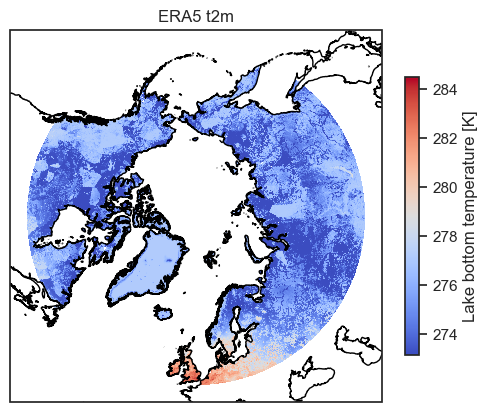

In [61]:
## View
variable = 't2m' # 'lblt' 'skt', 'stl4', 'stl1', 't2m'
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.coastlines(resolution="10m")

da.lblt.sel(time='2022-11-01').plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}) # geographic coords
plt.title(f"ERA5 {variable}")

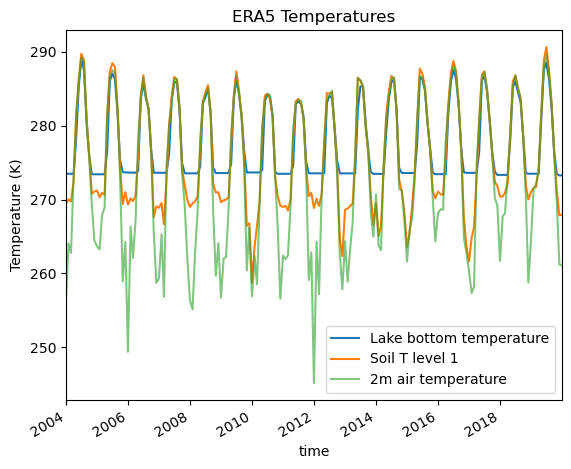

In [14]:
## Time series plot
fig, ax = plt.subplots()
lat, long = [60.460], [-161.450] # works
# lat, long = [66.55], [-164.452] # no data here
da.lblt.sel(latitude=lat, longitude=long, method='nearest').plot(ax=ax, label='Lake bottom temperature') # geographic coords
da.stl1.sel(latitude=lat, longitude=long, method='nearest').plot(ax=ax, label='Soil T level 1') # geographic coords
da.t2m.sel(latitude=lat, longitude=long, method='nearest').plot(ax=ax, label='2m air temperature', alpha=0.6) # geographic coords
ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2019-12-31')])
ax.set_title(f"ERA5 Temperatures")
ax.set_ylabel('Temperature (K)')
ax.legend()

In [15]:
## Practice loading from coords
da.lblt.sel(latitude=[60.460], longitude=[-161.450], time='2022-05-01', method='nearest')

<xarray.DataArray 'lblt' (latitude: 1, longitude: 1)>
array([[278.6705]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -161.5
  * latitude   (latitude) float32 60.5
    time       datetime64[ns] 2022-05-01
Attributes:
    units:      K
    long_name:  Lake bottom temperature

## Join in ERA5 temps

In [16]:
def pullTemp(df, da, lat_var='LAT', long_var='LONG', year_var='YEAR.S', month_var='MONTH', var='lblt', year=None):
    '''
    Merges in ERA5 temperature to an array based on 'LAT' and 'LONG' fields.
    
    Parameters
    ----------
    df : pd.DataFrame 
        df with lat, long, year, month fields as named below
    lat : str
        Field name to use for latitude (called "latitude" in ERA5)
    long : str
        Field name to use for longitude (called "longitude" in ERA5)
    year : str
        Field namae to use for year of observation (comes from "time" in ERA5)
    month : str
        Field namae to use for month of observation (comes from "time" in ERA5)
    da : xarray.DataSet
        ERA5 data
    var : str ('lblt)
        One of: 'lblt' 'skt', 'stl4', 'stl1', 't2m'
    
    Returns
    -------
    None

    Function appends new temp field onto dataset fields. If 'year' is given, 'year_var' and 'month_var' are ignored and all months are used for average.
    
    '''
    lt = df[lat_var]
    ln = df[long_var]
    if year is not None: # manual year supplied
        yr_list = [year]
        mth_list = np.arange(1,13)
    else: 
        # Get latitude, longitude, year, and month from the row
        # yr_list = parseYears(df[year_var]) # in case a range or list of years
        # mth_list = parseTimes(df[month_var]) # in case a range of months
        yr_list, mth_list = parseYearsMonths(df[year_var], df[month_var])

    
    # Select the temperature data from ERA5 using the given coordinates and time
    # da_tmp = da[var].where(da['time.year'].isin(yr), drop=True).sel(latitude=lt, longitude=ln, method='nearest')

    
    temprs = da[var].sel(latitude=lt, longitude=ln, method='nearest').sel(time=(da['time.year'].isin(yr_list)) & (da['time.month'].isin(mth_list)))

    ## reduce
    tempr = temprs.mean(dim='time')

    return tempr.values



In [17]:
## Apply with apply
df_era5 = df.copy()
tvars = ['lblt', 'skt', 'stl4', 'stl1', 't2m']
for tvar in tvars:
    # df_era5 = df.apply(pullTemp, args=(da,'LAT', 'LONG', 'YEAR.S', 'MONTH', tvar), axis=1)
    # df_era5 = df.apply(lambda row: pullTemp(row, da, var=tvar), axis=1)
    df_era5[f'ERA5_{tvar}'] = df.apply(lambda row: pullTemp(row, da, var=tvar), axis=1) # [f'ERA5_{tvar}']
    df_era5[f'ERA5_{tvar}'] = df_era5[f'ERA5_{tvar}'].astype('float') # to avoid type being 'object'

df_era5.head()

## Test on one row
# df1=df.iloc[23,:]
# pullTemp(df1, da)



,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,GRID_T,NOTES,DOI,CH4.E.FRAC,CH4.DE.FLUX,ERA5_lblt,ERA5_skt,ERA5_stl4,ERA5_stl1,ERA5_t2m
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,NaN,6.004,286.165161,287.401459,275.091309,287.020081,286.538513
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,0.592593,189.000,286.165161,287.401459,275.091309,287.020081,286.538513
2,3,1,Bartlett et al. 1992,WIK,1992,USA,CHAOS,1.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,NaN,3.160,286.165161,287.401459,275.091309,287.020081,286.538513
17,18,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL 66,1.0,73.09,-79.58,...,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,0.625000,3.840,276.597412,282.751709,267.084839,281.298035,279.319702
18,19,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL80,1.0,73.09,-79.58,...,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,0.651316,24.320,276.597412,282.751709,267.084839,281.298035,279.319702


In [30]:
## Write out

df_era5.to_csv(os.path.join(bawld_dir, 'BAWLD_CH4_Aquatic_ERA5.csv'))


In [29]:
## Filter out data with nans near coast with no ERA5-land data

df_era5.dropna(subset=['ERA5_lblt'], inplace=True) # 'TEMP'

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(3.96, 26.84, -6.557149658203102, 27.340816650390625)

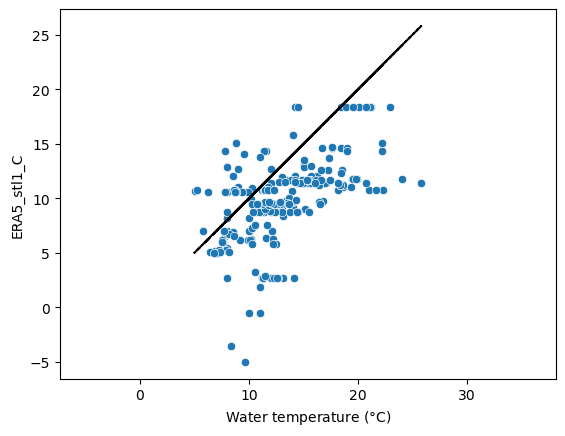

In [18]:
## Plot water TEMP vs modeled soil layer 1 temp

## Rescale to C
df_era5['ERA5_stl1_C'] = df_era5['ERA5_stl1'] -273.15

_, ax = plt.subplots()
# df_era5.plot.scatter(x='TEMP', y='ERA5_stl1_C', ax=ax)
sns.scatterplot(df_era5, x='TEMP', y='ERA5_stl1_C', ax=ax)
plt.plot(df_era5.TEMP, df_era5.TEMP, color='k', linestyle='--')
plt.xlabel('Water temperature ($\degree$C)')
ax.axis('equal')


In [19]:
## Add log transformations

df_era5['CH4.DE.FLUX.LOG'] = np.log10(df_era5['CH4.DE.FLUX'])
df_era5['SA.LOG'] = np.log10(df_era5.SA)

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Surface area ($log_{10}\\ km^2$)')

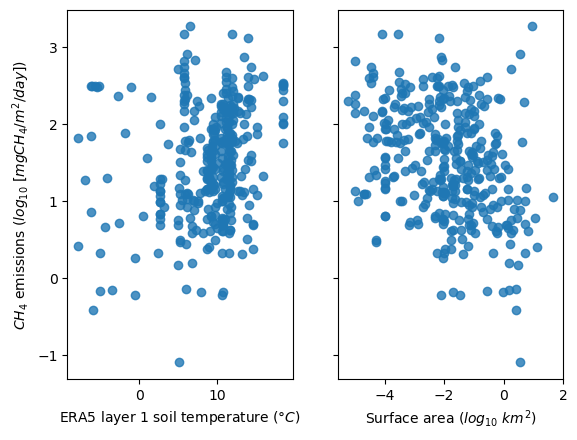

In [28]:
_, ax = plt.subplots(1,2, sharey=True)
sns.regplot(df_era5, x='ERA5_stl1_C', y='CH4.DE.FLUX.LOG', ax=ax[0])
sns.regplot(df_era5, x='SA.LOG', y='CH4.DE.FLUX.LOG', ax=ax[1])
ax[0].set_ylabel('$CH_4$ emissions ($log_{10}\ [mg CH_4/m^2/day$])')
ax[1].set_ylabel('')
ax[0].set_xlabel('ERA5 layer 1 soil temperature ($\degree C$)')
ax[1].set_xlabel('Surface area ($log_{10}\ km^2$)')


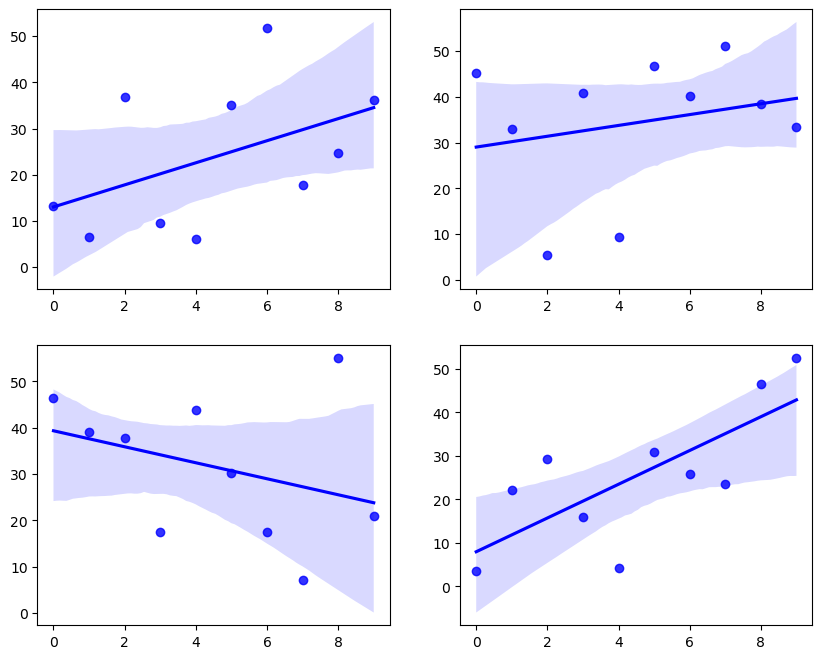

In [102]:
## Example of regression with noise: The slope of the trend can change!
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    sns.regplot(x=np.arange(10), y=np.arange(10)+np.random.random(10)*50, ax=ax, color='blue')



# Matching area histograms

In [44]:
## Load HL
# gdf_HL_jn_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_binned.shp'
df_HL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full.csv.gz' # main data source
df_hl = pd.read_csv(
    df_HL_jn_full_pth, compression='gzip', low_memory=False, usecols=['Lake_area', 'Hylak_id'])

## 
# # gdf_HL_jn_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_binned.shp'
# gdf_hl = gpd.read_file(
#     gdf_HL_jn_pth, engine='pyogrio', read_geometry=False)

df_hl['Lake_area_log'] = np.log10(df_hl['Lake_area'])

In [57]:
np.arange(-5,2)

array([-5, -4, -3, -2, -1,  0,  1])

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

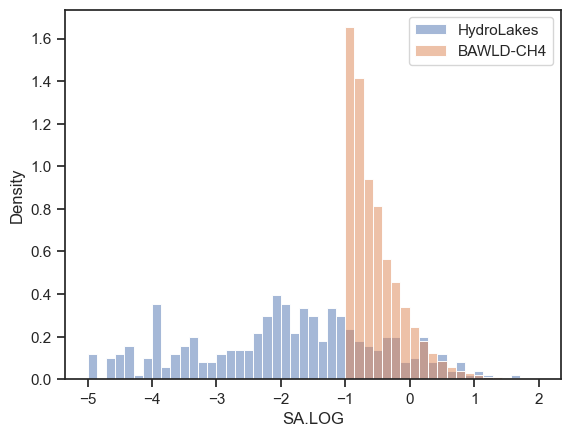

In [60]:
fig, ax = plt.subplots()
sns.histplot(df_era5['SA.LOG'], ax=ax, alpha=0.5, stat='density', bins=np.linspace(-5,2, 50), label='HydroLakes')
sns.histplot(df_hl['Lake_area_log'], ax=ax, alpha=0.5, stat='density', bins=np.linspace(-5,2, 50), label='BAWLD-CH4')
plt.legend()

# BAWLD regression

## Initial tests with builtin data

In [31]:
## Rescale everything to degC to easily compare coefficients
df_era5['GRID_T'] = df_era5.GRID_T + 273.15
df_era5['TEMP'] = df_era5.TEMP + 273.15

In [20]:
## Linear models (regression) v0
formula1 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula1, data=df_era5).fit() # uses water temp
formula2 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + GRID_T" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model2 = ols(formula=formula2, data=df_era5).fit() # uses MAAT
formula3 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + np.power(TEMP, 2)" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model3 = ols(formula=formula3, data=df_era5).fit() # uses MAAT

# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.126
Model:                                           OLS   Adj. R-squared:                  0.118
Method:                                Least Squares   F-statistic:                     16.24
Date:                               Fri, 22 Sep 2023   Prob (F-statistic):           2.57e-07
Time:                                       17:22:56   Log-Likelihood:                -238.08
No. Observations:                                228   AIC:                             482.2
Df Residuals:                                    225   BIC:                             492.4
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -15.8035      3.292     -4.800      0.000     -22.292      -9.316
np.log10(SA)    -0.0607      0.038     -1.603      0.110      -0.135       0.014
TEMP             0.0597      0.012      5.177      0.000       0.037       0.082
==============================================================================
Omnibus:                       78.165   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.445
Skew:                          -1.223   Prob(JB):                     2.50e-93
Kurtosis:                       9.237   Cond. No.                     2.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Additional models with ERA5 temps

In [21]:
## Try with reanalysis temps

m5_models = {}
for i, tvar in enumerate(tvars):
    formula = f"np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + ERA5_{tvar}"
    m5_models[f'model{i+4}'] = ols(formula=formula, data=df_era5).fit()

In [22]:
## Compare model using water temp vs MAAT. First column is after filtering by TEMP and ice-free. Second column is without and shows less difference bw variable.
model1.rsquared # 0.115 # 0.106 # water temp
model2.rsquared # 0.046 # 0.109 # MAAT
model3.rsquared # 0.116 # 0.108 # water temp squared - hardly an improvement! Justification for linear.
# TODO: model that uses monthly or daily air temp!

0.1263074609394388

In [28]:
## Add soil T squared
formula9 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + np.power(ERA5_stl1, 2)" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model9 = ols(formula=formula9, data=df_era5).fit() # uses water temp

In [29]:
## Record regression results in a table

models = [model1, model2, model3] + [m5_models[f'model{n}'] for n in range(4,9)] + [model9]
notes = ['water temp', 'MAAT', 'Water temp squared', 'Modeled lake bottom T', 'Modeled skin T', 'Modeled soil T level 4','Modeled soil T level 1','2m air T', 'Soil T level 1 squared']
model_names = [f'model{n}' for n in range(1,len(models)+1)]
rsq = [model.rsquared for model in models]
eqn = [f"y = {model.params['Intercept']:.2f} + {model.params.iloc[1]:.2f}*{model.params.index[1]} + {model.params.iloc[2]:.2f}*{model.params.index[2]}" for model in models]
pval_1 = [model.pvalues.iloc[1] for model in models]
pval_2 = [model.pvalues.iloc[2] for model in models]

model_summ = pd.DataFrame({'Model Name': model_names, 'R-Squared': rsq, 'P (SA)': pval_1, 'P (Temp)': pval_2, 'Equation':eqn, 'Note': notes})
model_summ.sort_values('R-Squared', ascending=False)


,Model Name,R-Squared,P (SA),P (Temp),Equation,Note
8,model9,0.220785,5.831400e-09,1.268755e-11,y = -7.61 + -0.18*np.log10(SA) + 0.00*np.power...,Soil T level 1 squared
6,model7,0.220548,6.234585e-09,1.340103e-11,y = -16.10 + -0.18*np.log10(SA) + 0.06*ERA5_stl1,Modeled soil T level 1
7,model8,0.213699,3.829168e-08,6.475748e-11,y = -10.04 + -0.18*np.log10(SA) + 0.04*ERA5_t2m,2m air T
4,model5,0.203249,1.421529e-08,7.012647e-10,y = -8.66 + -0.18*np.log10(SA) + 0.03*ERA5_skt,Modeled skin T
5,model6,0.154894,4.054130e-09,3.281744e-05,y = -15.55 + -0.19*np.log10(SA) + 0.06*ERA5_stl4,Modeled soil T level 4
3,model4,0.145528,2.229945e-11,2.567670e-04,y = -13.15 + -0.22*np.log10(SA) + 0.05*ERA5_lblt,Modeled lake bottom T
2,model3,0.126307,1.103964e-01,4.905591e-07,y = -7.24 + -0.06*np.log10(SA) + 0.00*np.power...,Water temp squared
0,model1,0.126174,1.102738e-01,4.993669e-07,y = -15.80 + -0.06*np.log10(SA) + 0.06*TEMP,water temp
1,model2,0.116323,7.334713e-11,1.274097e-01,y = -3.35 + -0.22*np.log10(SA) + 0.02*GRID_T,MAAT


In [30]:
## Write out

model_summ.to_csv(os.path.join(bawld_dir, 'Regression_table_v2.csv'))

In [287]:
## View best model

m5_models['model7'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.221
Model:                                           OLS   Adj. R-squared:                  0.216
Method:                                Least Squares   F-statistic:                     49.94
Date:                               Fri, 15 Sep 2023   Prob (F-statistic):           7.96e-20
Time:                                       18:50:44   Log-Likelihood:                -440.61
No. Observations:                                356   AIC:                             887.2
Df Residuals:                                    353   BIC:                             898.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -16.0989      2.450     -6.572      0.000     -20.917     -11.281
np.log10(SA)    -0.1838      0.031     -5.956      0.000      -0.245      -0.123
ERA5_stl1        0.0610      0.009      6.995      0.000       0.044       0.078
==============================================================================
Omnibus:                       91.907   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.744
Skew:                          -1.139   Prob(JB):                     2.22e-65
Kurtosis:                       6.858   Cond. No.                     1.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Add reannalysis temps to HL

In [100]:
## Load HL
gdf_hl = gpd.read_file('/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', engine='pyogrio', read_geometry=False, columns=['Hylak_id', 'Pour_long', 'Pour_lat'])
gdf_hl.head()

,Hylak_id,Pour_lat,Pour_long
0,1,45.591934,47.717708
1,2,65.138384,-123.505546
2,3,61.311727,-117.617115
3,4,53.696359,-97.863542
4,5,46.468593,-84.460547


In [124]:
## Fill NaNs in climate data (for coastal measurements)
da_filled = da.interpolate_na(dim='longitude', method='nearest')
da_sorted = da.sortby('latitude')
da_filled_lat = da_sorted.interpolate_na(dim='latitude', method='nearest')
da_filled = da_filled.combine_first(da_filled_lat)


In [128]:
## Fill NaNs in climate data (for coastal measurements)
da_filled = da.interpolate_na(dim=('latitude', 'longitude'), method='nearest') # Doesn't work for some reason

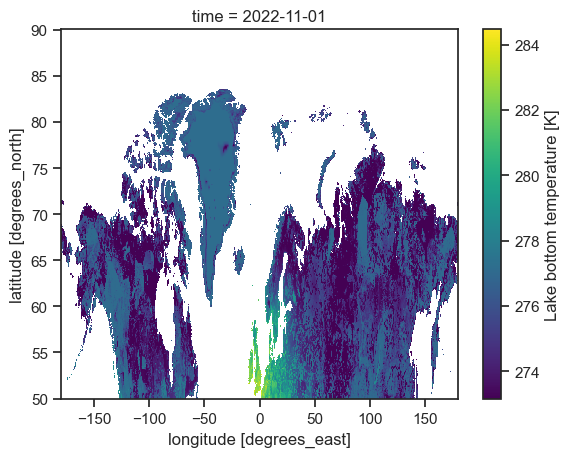

In [129]:
## Quick view
da_filled.lblt.sel(time='2022-11-01').plot() # geographic coords

In [102]:
## Test xarray call
da[['stl1', 'lblt']].sel(latitude=45.591934, longitude=47.717708, method='nearest').sel(time=(da['time.year'].isin([2022])) & (da['time.month'].isin(np.arange(1,13))))


<xarray.Dataset>
Dimensions:    (time: 12)
Coordinates:
    longitude  float32 47.75
    latitude   float32 50.0
  * time       (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
Data variables:
    stl1       (time) float32 272.5 273.1 273.2 284.8 ... 283.8 276.5 270.3
    lblt       (time) float32 273.8 273.8 273.8 278.6 ... 282.9 277.9 273.6
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-15 19:48:12 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [68]:
## Test function on gdf_hl

# df1 = gdf_hl.loc[:5, :].compute()
df1 = gdf_hl.get_partition(0).compute()
df1

,Hylak_id,Pour_lat,Pour_long
0,1,45.591934,47.717708
1,2,65.138384,-123.505546
2,3,61.311727,-117.617115
3,4,53.696359,-97.863542
4,5,46.468593,-84.460547
...,...,...,...
178456,178457,18.366440,99.754058
178457,178458,18.356131,78.301739
178458,178459,18.343432,83.196426
178459,178460,18.334034,74.613542


In [ ]:
## Test on first partition (works!)
df1.apply(lambda row: pullTemp(row, da, lat_var='Pour_lat', long_var='Pour_long', var='stl1', year=2022), axis=1)

In [18]:
## turn back into pd df
gdf_hl = gdf_hl.compute()

In [130]:
## Add temps (No Dask)
tvar = 'stl1'
temps = gdf_hl.apply(lambda row: pullTemp(row, da_filled, lat_var='Pour_lat', long_var='Pour_long', var='stl1', year=2022), axis=1) # .astype('float')
# gdf_hl[f'ERA5_{tvar}'] = 

In [131]:
## Add to gdf
gdf_hl[f'ERA5_{tvar}'] = temps.astype('float')

In [132]:
## View
gdf_hl

,Hylak_id,Pour_lat,Pour_long,ERA5_stl1
0,1,45.591934,47.717708,284.426178
1,2,65.138384,-123.505546,277.859100
2,3,61.311727,-117.617115,278.569916
3,4,53.696359,-97.863542,278.841064
4,5,46.468593,-84.460547,279.909363
...,...,...,...,...
1427683,1427684,-52.592307,169.147152,NaN
1427684,1427685,-52.973622,73.305108,281.573761
1427685,1427686,-54.529970,158.892278,NaN
1427686,1427687,-54.594300,158.889583,NaN


In [93]:
## Add temps (Dask)
# tvars = ['stl1'] # ['lblt', 'skt', 'stl4', 'stl1', 't2m'] # redundant, copied here
# for tvar in tvars:
#     gdf_hl[f'ERA5_{tvar}'] = gdf_hl.apply(lambda row: pullTemp(row, da_filled, lat_var='Pour_lat', long_var='Pour_long', var=tvar, year=2022), axis=1) # .astype('float') # to avoid type being 'object'

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/dask/dataframe/core.py:6003: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


KeyboardInterrupt: 

In [134]:
## How many NaNs?
np.isnan(gdf_hl[f'ERA5_stl1']).sum()

75778

In [136]:
## Fill nans with mean
gdf_hl[f'ERA5_stl1'].fillna(gdf_hl[f'ERA5_stl1'].mean(), inplace=True)
gdf_hl[f'ERA5_stl1']

0          284.426178
1          277.859100
2          278.569916
3          278.841064
4          279.909363
              ...    
1427683    275.980649
1427684    281.573761
1427685    275.980649
1427686    275.980649
1427687    275.980649
Name: ERA5_stl1, Length: 1427688, dtype: float64

In [137]:
## Write out ## TODO: as shapefile
gdf_hl.to_csv('/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/out/joined_ERA5/HL_ERA5_stl1_v3.csv.gz')

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)


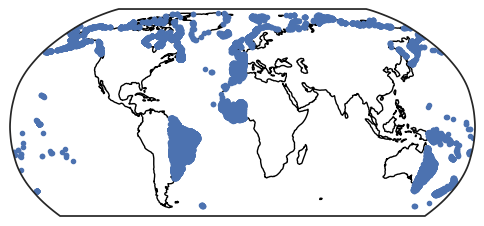

In [122]:
## Where are the nans?

nans = gdf_hl[np.isnan(gdf_hl[f'ERA5_stl1'])]
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="110m")
plt.plot(nans.Pour_long, nans.Pour_lat, '.', transform=ccrs.PlateCarree()) #, ax=ax) # geographic coords

# Compare BAWLD vs HL areas

## Start with Yashwin's BAWLD vs PLD

In [ ]:
## Load andf filter Yashwin's shorelines
df_shorelines = gpd.read_file('/Volumes/thebe/Global-lake-shorelines/digitizing/Yashwin/EDK_updated/global_shorelines2023912_edk_lambert.shp', engine='pyogrio', read_geometry=False)
df_shorelines.drop(index=df_shorelines[(df_shorelines.layer != 'BAWLD_lakes') | (df_shorelines.Skipped == 1)].index, inplace=True)
df_shorelines

,ID,STUDY,DATASET,YEAR,COUNTRY,SITE,LAT,LONG,SA,DEPTH,...,ref_wse,Shape_Leng,Shape_Area,Img_src,rownum,dup,EDK_flag,area,perimeter,A_km2_dig
332,320,Phelps et al. 1998,WIK,1998.0,USA,Goose Lake,61.120000,-149.490000,0.2,2.2,...,NaN,NaN,NaN,Google_imagery,333.0,0.0,NaN,1.668801e+05,2589.786545,0.167
337,333,Repo et al. 2007,WIK,2007.0,Canada,FTLake,58.450000,-94.090000,0.07,1.4,...,NaN,NaN,NaN,Google_imagery,338.0,0.0,NaN,5.586612e+04,2912.772065,0.056
357,366,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Grayling,66.950000,-150.390000,0.401,1.8,...,NaN,NaN,NaN,PLD,359.0,NaN,NaN,3.474913e+05,3532.708826,0.347
358,377,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Scout,60.530000,-150.840000,0.384,6.3,...,NaN,NaN,NaN,PLD,361.0,NaN,NaN,2.710235e+05,4045.186762,0.271
359,378,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Swampbuggy,63.060000,-147.420000,0.142,4.9,...,NaN,NaN,NaN,PLD,363.0,NaN,NaN,1.297023e+05,2278.438458,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,227,Kuhn et al. unpublished,KUHN,2020.0,Canada,W1,63.151000,-123.249000,0.042,3.5,...,NaN,NaN,NaN,Google_imagery,738.0,0.0,NaN,3.569225e+04,1699.992164,0.036
734,228,Kuhn et al. unpublished,KUHN,2020.0,Canada,W2,63.151000,-123.249000,0.01,1.1,...,NaN,NaN,NaN,Google_imagery,739.0,0.0,NaN,8.606812e+03,622.662269,0.009
735,229,Kuhn et al. unpublished,KUHN,2020.0,Canada,W3,63.151000,-123.249000,0.005,0.8,...,NaN,NaN,NaN,Google_imagery,740.0,0.0,NaN,2.456315e+03,219.795203,0.002
790,473,Serikova et al. 2019,KUHN,2016.0,Russia,LKh5,63.812778,75.701111,0.008248,0.875,...,-1.000000e+12,0.180292,0.000257,PLD,795.0,0.0,NaN,1.414088e+06,12086.229932,1.414


/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


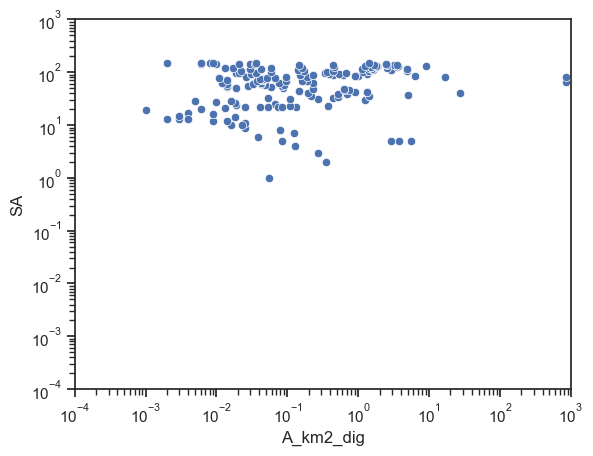

In [ ]:
## Plot ## Problem: area are off by orders of magnitude without extra manual filtering... can't show this.
df_shorelines[['A_km2_dig', 'SA']]
sns.scatterplot(df_shorelines, x='A_km2_dig', y='SA')
plt.xlim([0.0001, 1000])
plt.ylim([0.0001, 1000])
plt.xscale('log')
plt.yscale('log')

## Now try with HL vs BAWLD

In [ ]:
## Load BAWLD-CH4 joined to HL lakes as shapefile, and preprocess
df_shorelines = gpd.read_file('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/joined-to-hl/bawld-ch4-hl.shp', engine='pyogrio', read_geometry=False)
df_shorelines.replace('-', np.nan, inplace=True)
df_shorelines['SA'] = df_shorelines['SA'].astype('float')
df_shorelines.drop(index=df_shorelines[(df_shorelines['NUMBER.LAK'] !=  '1') | (df_shorelines['SA'] < 0.1)].index, inplace=True)
df_shorelines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 1 to 65
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          42 non-null     int64  
 1   NUM         42 non-null     int64  
 2   STUDY       42 non-null     object 
 3   DATASET     42 non-null     object 
 4   YEAR        42 non-null     int64  
 5   COUNTRY     42 non-null     object 
 6   SITE        42 non-null     object 
 7   NUMBER.LAK  42 non-null     object 
 8   LAT         42 non-null     float64
 9   LONG        42 non-null     float64
 10  ECOREGION   42 non-null     object 
 11  PERMA.ZONE  42 non-null     object 
 12  LAKE.TYPE   42 non-null     object 
 13  BOTTOM      42 non-null     object 
 14  TALIK       30 non-null     object 
 15  SA          40 non-null     float64
 16  DEPTH       37 non-null     object 
 17  SEASON      42 non-null     object 
 18  YEAR.S      42 non-null     object 
 19  MONTH       42 non-null     object 


/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.0, 2.0)

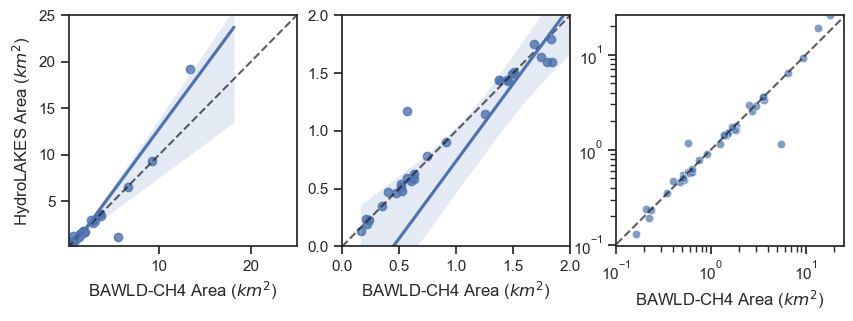

In [ ]:
## Plot
fig, ax = plt.subplots(1,3, figsize=(10,3))
lim = [0.1, 25]
for a in ax:
    a.plot([0.000001, 100000], [0.000001, 100000], '--k', alpha=0.7)
    plt.axis('equal')
sns.regplot(df_shorelines, x='SA', y='Lake_area', ax=ax[0]) 
sns.regplot(df_shorelines, x='SA', y='Lake_area', ax=ax[1]) 
sns.scatterplot(df_shorelines, x='SA', y='Lake_area', alpha=0.7, ax=ax[2])

for a in ax:
    a.set_xlabel('BAWLD-CH4 Area ($km^2$)')
    a.set_xlim(lim)
    a.set_ylim(lim)
ax[0].set_ylabel('HydroLAKES Area ($km^2$)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[1].set_xlim([0, 2])
ax[1].set_ylim([0, 2])

In [ ]:
## Print metrics of fit
df_shorelines = df_shorelines.dropna(subset=['SA','Lake_area'])
corr_coeff, p_value = pearsonr(df_shorelines['SA'], df_shorelines['Lake_area'])
print(f'Correlation: {corr_coeff:0.2%}')
print(f'P: {p_value:0.2%}')

Correlation: 97.09%
P: 0.00%


# Scratch

In [ ]:
## Test: Try again w all vars at once vectorized

df_era5 = df.copy()
tvars = ['lblt', 'skt', 'stl4', 'stl1', 't2m']

# da[tvars].sel(latitude=45.591934, longitude=47.717708, method='nearest').sel(time=(da['time.year'].isin([1988, 2022])) & (da['time.month'].isin(np.arange(1,13))))

df.apply(lambda row: pullTemp(row, da, var=tvars), axis=1) # [tvars] # this
# df_era5[f'ERA5_{tvar}'].astype('float') # to avoid type being 'object'

# foo

0      <bound method Mapping.values of <xarray.Datase...
1      <bound method Mapping.values of <xarray.Datase...
2      <bound method Mapping.values of <xarray.Datase...
17     <bound method Mapping.values of <xarray.Datase...
18     <bound method Mapping.values of <xarray.Datase...
                             ...                        
540    <bound method Mapping.values of <xarray.Datase...
542    <bound method Mapping.values of <xarray.Datase...
543    <bound method Mapping.values of <xarray.Datase...
544    <bound method Mapping.values of <xarray.Datase...
552    <bound method Mapping.values of <xarray.Datase...
Length: 363, dtype: object